## Making a QAOA Circuit

In [218]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.primitives import BackendEstimator,BackendSampler

In [219]:
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz

from qiskit import transpile
from qiskit_aer import AerSimulator
# from qiskit.visualization import plot_distribution
#from qiskit.quantum_info import SparsePauliOp
# Qiskit Runtime
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
# from rustworkx.visualization import mpl_draw

In [220]:

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



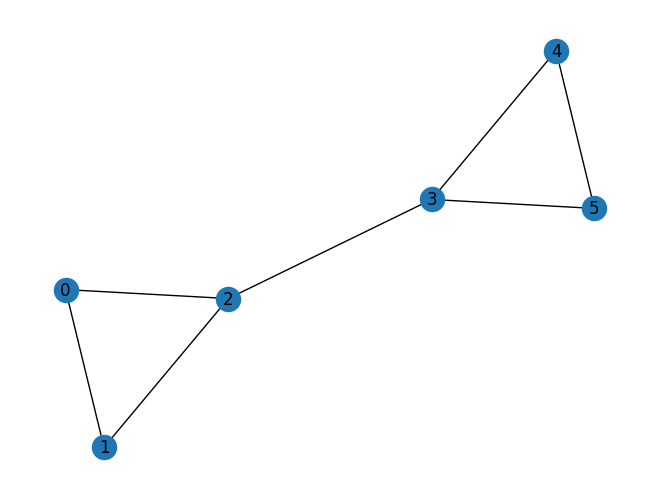

In [221]:


seed = 12
num_nodes = 6



# G = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
# nx.draw(G, with_labels=True, pos=nx.spring_layout(G, seed=seed))


G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0),(3,2),(4,3),(5,3),(4,5)])
nx.draw_spring(G, with_labels=True)
maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [222]:
# Initialize the weight matrix
w = np.zeros((num_nodes, num_nodes))

# Iterate over the edges of the graph and assign weights to the weight matrix
for edge in G.edges():
    node1, node2 = edge
    w[node1][node2] = 1
    w[node2][node1] = 1  # Assuming undirected graph

# Print the weight matrix
#print("Weight Matrix:")
#print(w)

In [223]:
import time
pos = nx.spring_layout(G)

case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0, 0, 0] cost = 2.0
case = [1, 1, 0, 0, 0, 0] cost = 2.0
case = [0, 0, 1, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 0, 0] cost = 3.0
case = [0, 1, 1, 0, 0, 0] cost = 3.0
case = [1, 1, 1, 0, 0, 0] cost = 1.0
case = [0, 0, 0, 1, 0, 0] cost = 3.0
case = [1, 0, 0, 1, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0] cost = 5.0
case = [1, 1, 0, 1, 0, 0] cost = 5.0
case = [0, 0, 1, 1, 0, 0] cost = 4.0
case = [1, 0, 1, 1, 0, 0] cost = 4.0
case = [0, 1, 1, 1, 0, 0] cost = 4.0
case = [1, 1, 1, 1, 0, 0] cost = 2.0
case = [0, 0, 0, 0, 1, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0] cost = 4.0
case = [0, 1, 0, 0, 1, 0] cost = 4.0
case = [1, 1, 0, 0, 1, 0] cost = 4.0
case = [0, 0, 1, 0, 1, 0] cost = 5.0
case = [1, 0, 1, 0, 1, 0] cost = 5.0
case = [0, 1, 1, 0, 1, 0] cost = 5.0
case = [1, 1, 1, 0, 1, 0] cost = 3.0
case = [0, 0, 0, 1, 1, 0] cost = 3.0
case = [1, 0, 0, 1, 1, 0] cost = 5.0
case = [0, 1, 0, 1, 1, 0] cost = 5.0
c

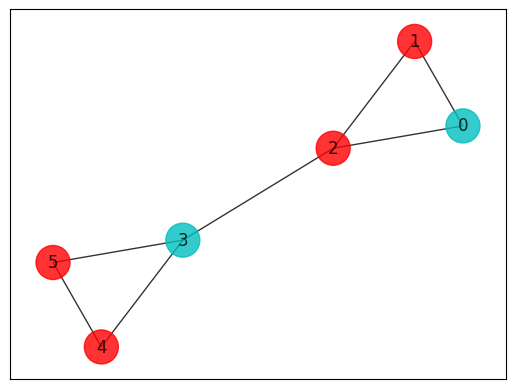

In [224]:
tic = time.time()
best_cost_brute = 0
for b in range(2**num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(num_nodes)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")

In [225]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



### Make a Hamiltonian out of it

In [226]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -3.5
Ising Hamiltonian:
SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [227]:
# Problem to Hamiltonian operator
hamiltonian = qubitOp

In [228]:
print(hamiltonian)

SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### Make the QAOA from ansatz

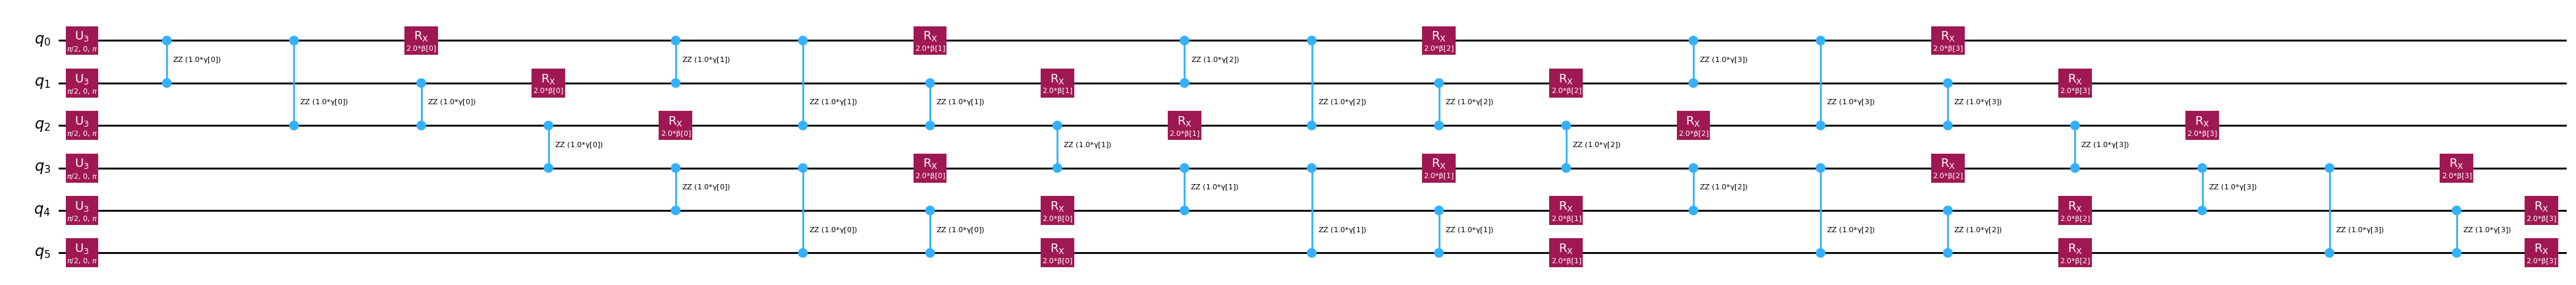

In [231]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=4)

# the reps in decompose means, the number of times the circuit should be decomposed
# for example reps = 2 means circuit.decompise().decompose()
ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [232]:
print(f"Number of Qubits: {ansatz.num_qubits}")
print(f"Number of Parameters: {ansatz.num_parameters}")


Number of Qubits: 6
Number of Parameters: 8


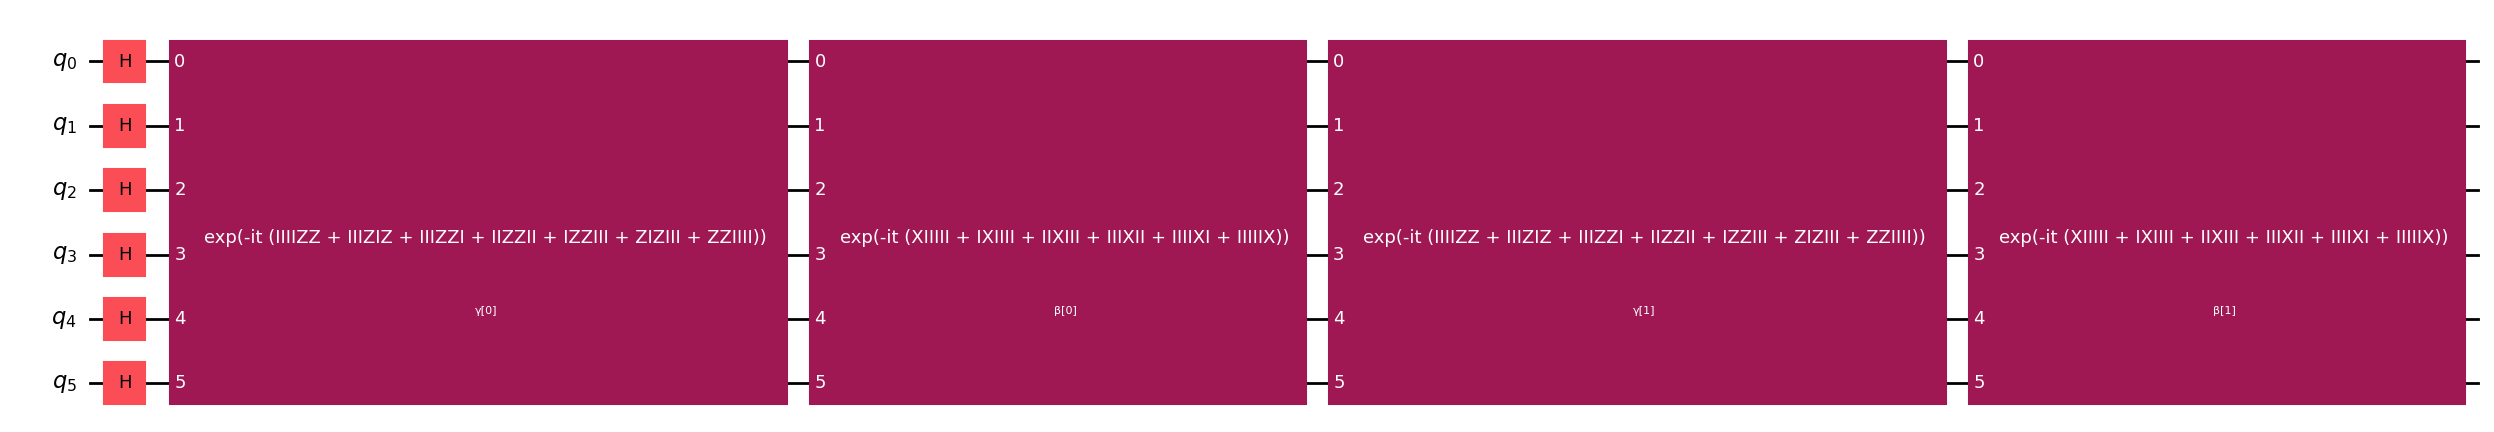

In [147]:
ansatz.decompose().draw(output="mpl", style="iqp",fold=-1)

### Run the Uncut Circuit

In [129]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [130]:
def cost(params,probs):
    avg_cost = 0
    for sample in probs.keys():
        x = [int(bit) for bit in list(sample)]
        # Cost function is Hamming weight
        avg_cost += probs[sample] * sum(x)

    return -avg_cost


In [16]:
print(hamiltonian)

SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [17]:
backend = AerSimulator(method='statevector')

In [18]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.46.0', 'qiskit-aer': '0.13.3', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.6.1', 'qiskit-machine-learning': '0.7.1'}

In [19]:
estimator = BackendEstimator(backend=backend)
sampler = BackendSampler(backend=backend)

In [152]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
print(x0)

[0.17661295 3.32862635 2.01783794 0.21347345]


In [21]:
tic = time.time()
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="POWELL", options={"maxiter": 100})
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")


elapsed time = 16.071303129196167 sec


In [89]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [93]:
y = estimator.run(ansatz, hamiltonian, parameter_values=res.x).result()
y

EstimatorResult(values=array([-1.31640625]), metadata=[{'variance': 1.4727935791015625, 'shots': 1024}])

In [91]:
cost_func(x0, ansatz, hamiltonian, estimator)

1.400390625

In [22]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -1.3154296875
       x: [ 1.276e+00  6.931e+00  5.277e+00  3.718e-01]
     nit: 7
   direc: [[ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]
           [ 1.228e-01  3.877e-02  1.916e-01 -6.861e-02]
           [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
           [ 9.603e-03 -2.885e-02  6.756e-03 -2.941e-02]]
    nfev: 458

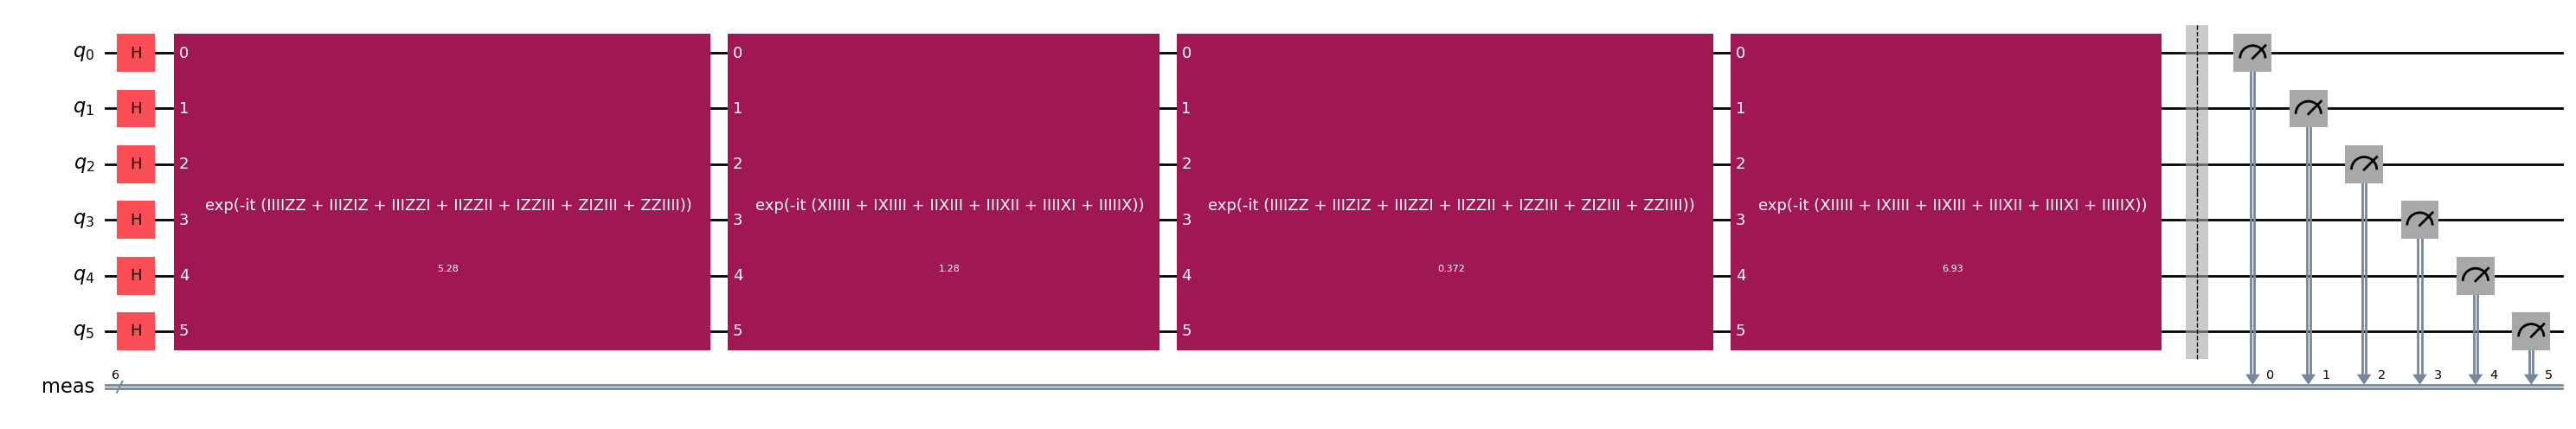

In [23]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc.decompose().draw(output="mpl",style = 'iqx',fold=-1)

In [24]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]
my_dict = dict(sorted(samp_dist.binary_probabilities().items(),key=lambda item: item[1], reverse=True))
#my_dict = samp_dist.binary_probabilities()
print(my_dict) 

{'010110': 0.0615234375, '011001': 0.060546875, '100110': 0.0556640625, '010101': 0.0537109375, '011010': 0.052734375, '101001': 0.0478515625, '001001': 0.046875, '101010': 0.046875, '100101': 0.0458984375, '001010': 0.0458984375, '100100': 0.04296875, '010100': 0.041015625, '110101': 0.0400390625, '011011': 0.0400390625, '110100': 0.0400390625, '110110': 0.0400390625, '101011': 0.0390625, '001011': 0.0322265625, '110011': 0.01953125, '010001': 0.0146484375, '101100': 0.0107421875, '110001': 0.009765625, '100010': 0.009765625, '101110': 0.009765625, '110010': 0.009765625, '100001': 0.0087890625, '011101': 0.0078125, '100011': 0.0068359375, '001100': 0.0068359375, '001101': 0.005859375, '001110': 0.0048828125, '101101': 0.0048828125, '011100': 0.0048828125, '011110': 0.0048828125, '010010': 0.0048828125, '010011': 0.0048828125, '011000': 0.0029296875, '000110': 0.001953125, '000101': 0.001953125, '101111': 0.0009765625, '111010': 0.0009765625, '001111': 0.0009765625, '111100': 0.0009765

In [25]:
print("Brute Force Solution: ", xbest_brute)
# first result from my_dict
print("QAOA Solution: ", list(my_dict.keys())[0])

Brute Force Solution:  [1, 0, 0, 1, 0, 0]
QAOA Solution:  010110


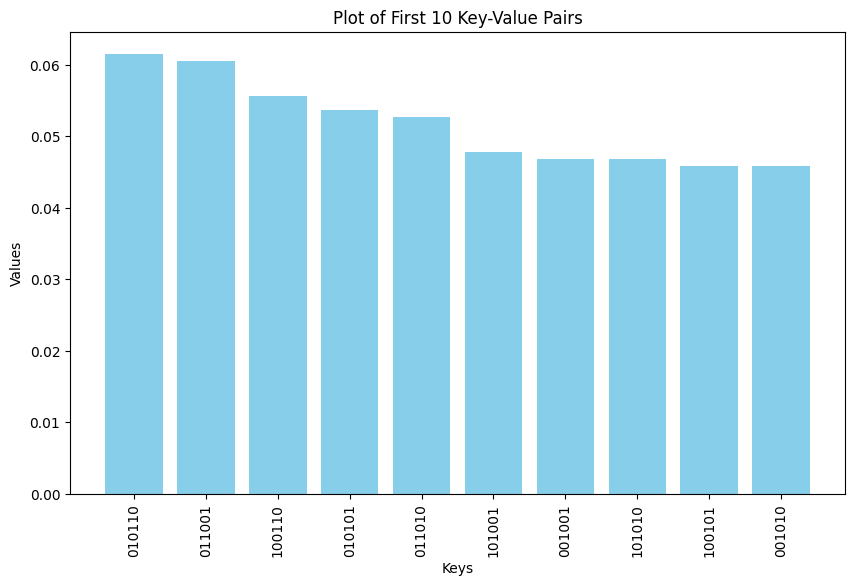

In [26]:
# plot the histogram of my_dict, for only first 10 elements
# Extract first 10 key-value pairs
first_10_items = list(my_dict.items())[:10]
x_values = [item[0] for item in first_10_items]
y_values = [item[1] for item in first_10_items]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='skyblue')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Plot of First 10 Key-Value Pairs')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [148]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

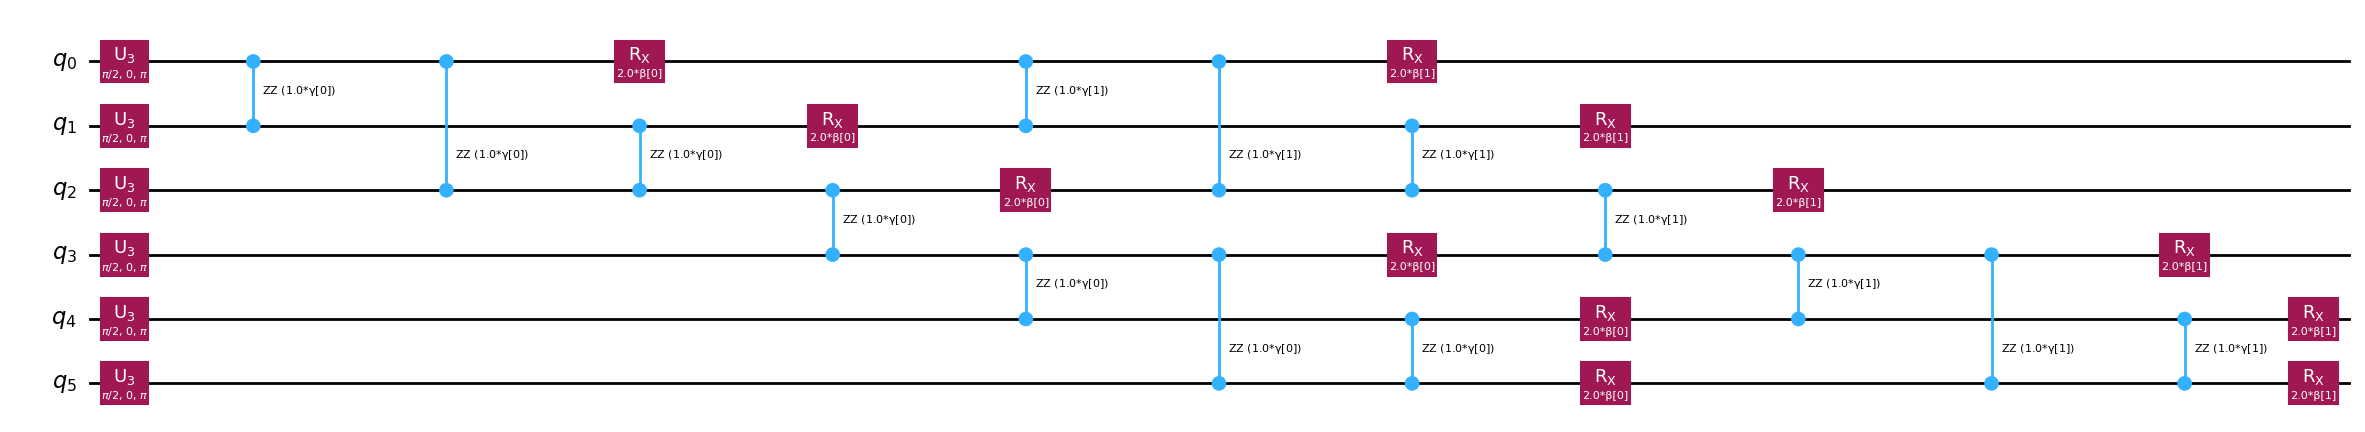

In [149]:

ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [150]:
print(f"Number of Qubits: {ansatz.num_qubits}")
print(f"Number of Parameters: {ansatz.num_parameters}")


Number of Qubits: 6
Number of Parameters: 4


### Transpile it, so that it's easy to cut

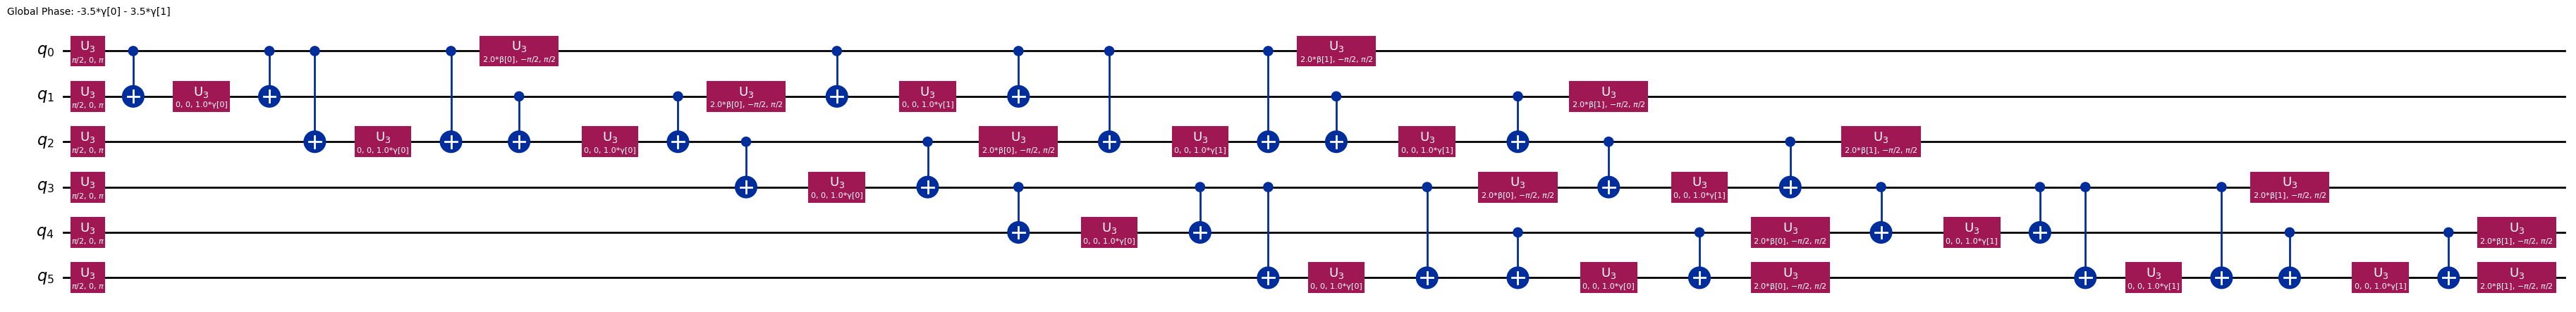

In [161]:
circuit_basis = transpile(ansatz, basis_gates=['u3', 'cx'], optimization_level=3)
circuit_basis.draw(output="mpl", style="iqp",fold=-1)

### Invoke the Wire Cutting

```python
cuts = cut_circuit_wires(
    circuit=circuit_basis,
    method="automatic",
    max_subcircuit_width=8,
    max_cuts=400,
    num_subcircuits=[4],
)
```

Assign the parameters before cutting

In [162]:
circuit_basis = circuit_basis.assign_parameters(x0)

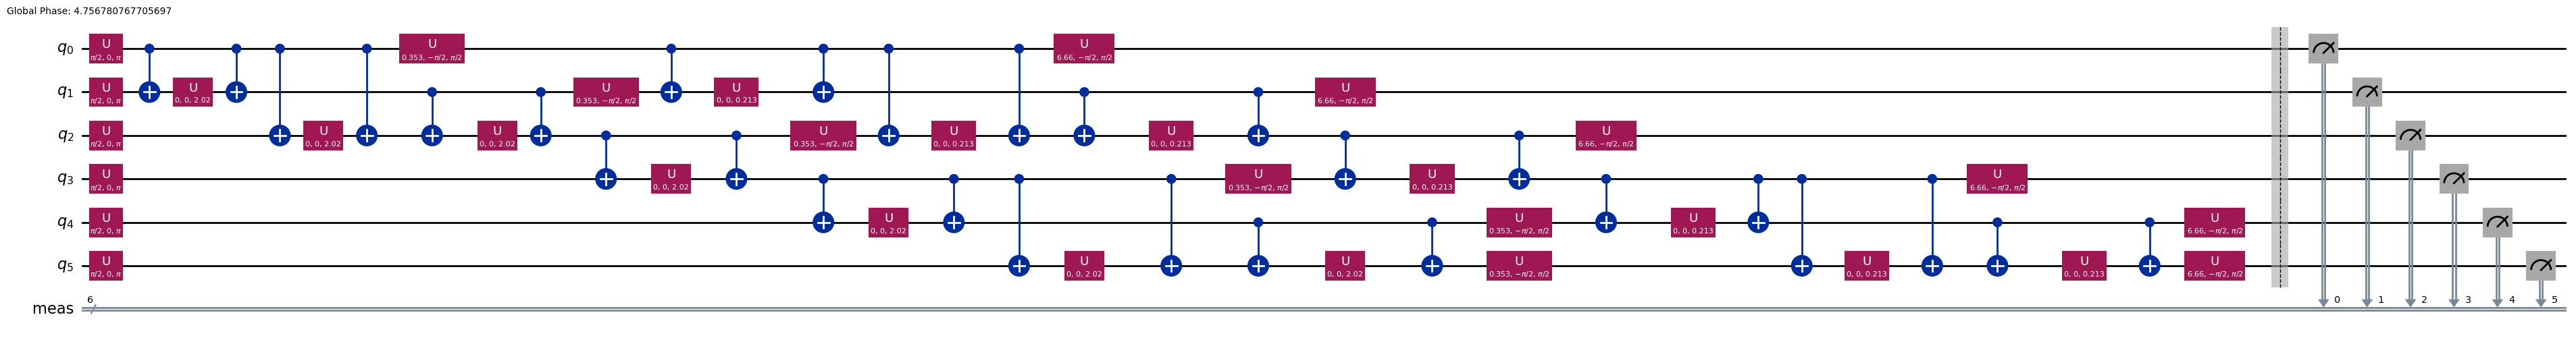

In [154]:
circuit_basis.measure_all()
circuit_basis.decompose().draw(output="mpl", style="iqp",fold=-1)

In [155]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(circuit_basis).result().quasi_dists[0]
my_dict = dict(sorted(samp_dist.binary_probabilities().items(),key=lambda item: item[1], reverse=True))
#my_dict = samp_dist.binary_probabilities()
print(my_dict) 

{'001011': 0.0556640625, '101110': 0.0419921875, '110100': 0.0400390625, '011110': 0.0390625, '010010': 0.037109375, '011100': 0.0361328125, '101101': 0.03515625, '110010': 0.03515625, '100001': 0.03515625, '101100': 0.0341796875, '010001': 0.033203125, '011101': 0.033203125, '100010': 0.0322265625, '010011': 0.029296875, '110001': 0.029296875, '100011': 0.0283203125, '001110': 0.0263671875, '001101': 0.025390625, '110110': 0.0224609375, '101011': 0.0224609375, '110011': 0.021484375, '001001': 0.021484375, '100100': 0.017578125, '110101': 0.017578125, '001100': 0.015625, '001010': 0.015625, '000110': 0.0146484375, '000101': 0.0146484375, '010111': 0.0146484375, '011011': 0.0146484375, '010100': 0.0146484375, '110111': 0.013671875, '000100': 0.0126953125, '111011': 0.01171875, '100111': 0.01171875, '111010': 0.009765625, '001000': 0.009765625, '011000': 0.009765625, '011010': 0.0068359375, '111001': 0.0068359375, '011001': 0.005859375, '101001': 0.0048828125, '010101': 0.0048828125, '11

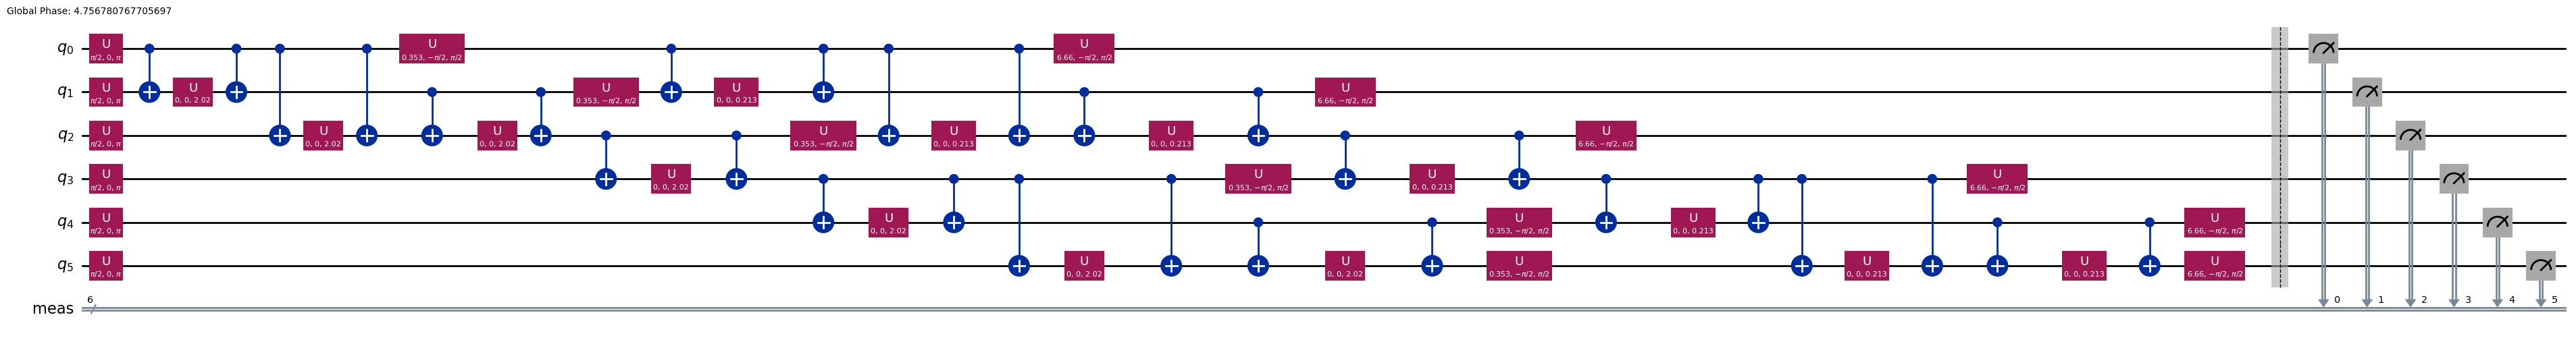

In [156]:
circuit_basis.decompose().draw(output="mpl", style="iqp",fold=-1)

In [163]:
%%capture

from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=circuit_basis,
    method="automatic",
    max_subcircuit_width=4,
    max_cuts=400,
    num_subcircuits=[2],
)



In [217]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
print(x0)

[4.5641414  0.73711371 1.87013049 0.91461093]


In [164]:
print(f"Number of cuts: {cuts['num_cuts']}")

Number of cuts: 2


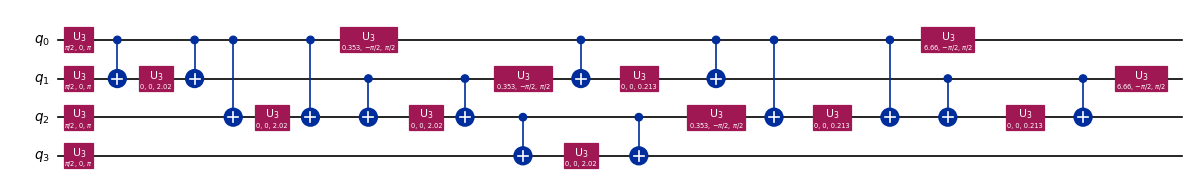

In [165]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl",style='iqx', fold=-1, scale=0.6)

In [166]:
cuts["subcircuits"][0].num_parameters

0

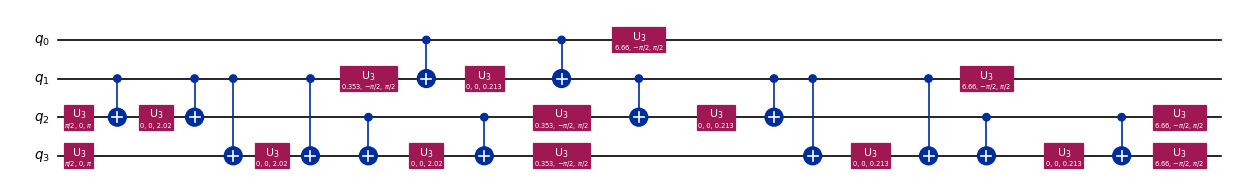

In [167]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl",style='iqx', fold=-1, scale=0.6)

In [168]:
cuts["subcircuits"][1].num_parameters

0

## Evaluate the Subcircuits

In [169]:
from qiskit_ibm_runtime import QiskitRuntimeService  # noqa: F401

# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime Service.
# service = QiskitRuntimeService()

### Configure the runtime Primitive

In [205]:
from qiskit_ibm_runtime import Options

# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

## Evaluate on backends

In [207]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits

#subcircuit_instance_probabilities = evaluate_subcircuits(cuts)

# Uncomment the following lines to instead use Qiskit Runtime Service as configured above.
subcircuit_instance_probabilities = evaluate_subcircuits(cuts,
                                                         backend_names=backend_names,
                                                         options=options,
                                                        )

## Inspecting the Subcircuit Results

In this case the original circuit was cut   times, you can get that information by:

In [208]:
print("Total number of cuts: ",cuts['num_cuts'])
print("Number of subcircuits: ",len(cuts['subcircuits']))
# or can do
print("Number of subcircuits: ",len(subcircuit_instance_probabilities))

Total number of cuts:  2
Number of subcircuits:  2
Number of subcircuits:  2


For these     wire cuts, there are $4^{} =  $ variants of the first subcircuit, and similary $4^{} = $ variants for the second, similarly for the third and same for fourth

In [209]:
print(
    "Number of variants of 1st subcircuit: ", len(subcircuit_instance_probabilities[0])
)
print(
    "Number of variants of 2nd subcircuit: ", len(subcircuit_instance_probabilities[1])
)


Number of variants of 1st subcircuit:  16
Number of variants of 2nd subcircuit:  16


In [210]:
%%capture

from circuit_knitting.cutting.cutqc import (
    reconstruct_full_distribution,
)

reconstructed_probabilities = reconstruct_full_distribution(
    circuit_basis, subcircuit_instance_probabilities, cuts
)

In [211]:
print(
    "Size of reconstructed probability distribution: ", len(reconstructed_probabilities)
)

Size of reconstructed probability distribution:  64


In [212]:
print(reconstructed_probabilities)

[0.00186921 0.00187872 0.00187872 0.00080419 0.01423543 0.0105043
 0.0105043  0.00252614 0.01423543 0.01813851 0.01813851 0.04644086
 0.01882863 0.03123189 0.03123189 0.00080419 0.00187872 0.03509788
 0.03509788 0.03123189 0.01813851 0.00321268 0.00321268 0.0105043
 0.0105043  0.00321268 0.00321268 0.01813851 0.03123189 0.03509788
 0.03509788 0.00187872 0.00187872 0.03509788 0.03509788 0.03123189
 0.01813851 0.00321268 0.00321268 0.0105043  0.0105043  0.00321268
 0.00321268 0.01813851 0.03123189 0.03509788 0.03509788 0.00187872
 0.00080419 0.03123189 0.03123189 0.01882863 0.04644086 0.01813851
 0.01813851 0.01423543 0.00252614 0.0105043  0.0105043  0.01423543
 0.00080419 0.00187872 0.00187872 0.00186921]


In [213]:
probs = reconstructed_distribution

In [214]:
print(probs)

{0: 0.0018692112556928328, 1: 0.001878723507702503, 2: 0.0018787235077024978, 3: 0.0008041918090355884, 4: 0.014235425912340876, 5: 0.01050430483598263, 6: 0.010504304835982624, 7: 0.002526136848860881, 8: 0.014235425912340872, 9: 0.01813850524862726, 10: 0.018138505248627274, 11: 0.04644085719867359, 12: 0.018828633715933987, 13: 0.03123188916023232, 14: 0.03123188916023232, 15: 0.0008041918090355774, 16: 0.001878723507702496, 17: 0.03509788331606285, 18: 0.03509788331606287, 19: 0.03123188916023232, 20: 0.018138505248627295, 21: 0.0032126753159141142, 22: 0.0032126753159141177, 23: 0.01050430483598261, 24: 0.010504304835982588, 25: 0.003212675315914095, 26: 0.0032126753159140917, 27: 0.018138505248627257, 28: 0.031231889160232326, 29: 0.035097883316062894, 30: 0.03509788331606288, 31: 0.0018787235077025203, 32: 0.0018787235077025125, 33: 0.035097883316062874, 34: 0.03509788331606288, 35: 0.031231889160232316, 36: 0.018138505248627285, 37: 0.0032126753159140795, 38: 0.0032126753159140

In [215]:
print(probs.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])


In [184]:
avg_cost = 0
for sample in probs.keys():
    x = [int(bit) for bit in list(sample)]
    # Cost function is Hamming weight
    avg_cost += probs[sample] * sum(x)

In [185]:
print("Cost of the solution: ", avg_cost)

Cost of the solution:  3.0000000000000053


In [198]:
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

print(reconstructed_distribution)

{0: 0.0018692112556928328, 1: 0.001878723507702503, 2: 0.0018787235077024978, 3: 0.0008041918090355884, 4: 0.014235425912340876, 5: 0.01050430483598263, 6: 0.010504304835982624, 7: 0.002526136848860881, 8: 0.014235425912340872, 9: 0.01813850524862726, 10: 0.018138505248627274, 11: 0.04644085719867359, 12: 0.018828633715933987, 13: 0.03123188916023232, 14: 0.03123188916023232, 15: 0.0008041918090355774, 16: 0.001878723507702496, 17: 0.03509788331606285, 18: 0.03509788331606287, 19: 0.03123188916023232, 20: 0.018138505248627295, 21: 0.0032126753159141142, 22: 0.0032126753159141177, 23: 0.01050430483598261, 24: 0.010504304835982588, 25: 0.003212675315914095, 26: 0.0032126753159140917, 27: 0.018138505248627257, 28: 0.031231889160232326, 29: 0.035097883316062894, 30: 0.03509788331606288, 31: 0.0018787235077025203, 32: 0.0018787235077025125, 33: 0.035097883316062874, 34: 0.03509788331606288, 35: 0.031231889160232316, 36: 0.018138505248627285, 37: 0.0032126753159140795, 38: 0.0032126753159140

In [199]:
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)

print(reconstructed_dict_bitstring)

{'000000': 0.0018692112556928328, '000001': 0.001878723507702503, '000010': 0.0018787235077024978, '000011': 0.0008041918090355884, '000100': 0.014235425912340876, '000101': 0.01050430483598263, '000110': 0.010504304835982624, '000111': 0.002526136848860881, '001000': 0.014235425912340872, '001001': 0.01813850524862726, '001010': 0.018138505248627274, '001011': 0.04644085719867359, '001100': 0.018828633715933987, '001101': 0.03123188916023232, '001110': 0.03123188916023232, '001111': 0.0008041918090355774, '010000': 0.001878723507702496, '010001': 0.03509788331606285, '010010': 0.03509788331606287, '010011': 0.03123188916023232, '010100': 0.018138505248627295, '010101': 0.0032126753159141142, '010110': 0.0032126753159141177, '010111': 0.01050430483598261, '011000': 0.010504304835982588, '011001': 0.003212675315914095, '011010': 0.0032126753159140917, '011011': 0.018138505248627257, '011100': 0.031231889160232326, '011101': 0.035097883316062894, '011110': 0.03509788331606288, '011111': 

In [203]:

def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [204]:
compute_expectation(reconstructed_dict_bitstring, G)

-4.0561113948422225

In [200]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    # pylint: disable=invalid-name
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj

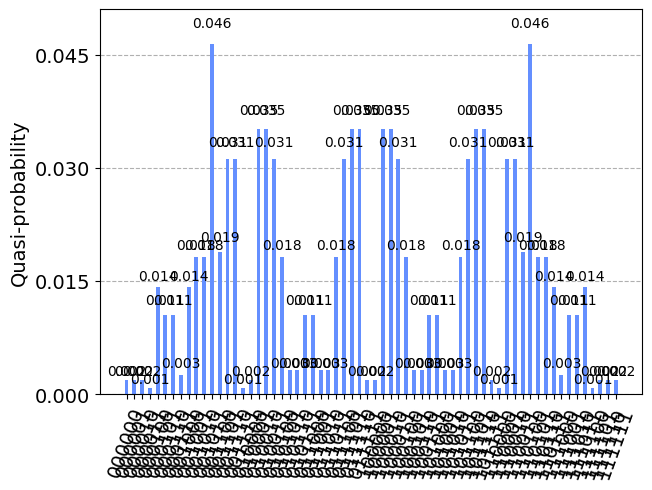

In [182]:
plot_histogram(reconstructed_dict_bitstring)

In [67]:
from circuit_knitting.cutting.cutqc import verify

metrics, exact_probabilities = verify(circuit_basis, reconstructed_probabilities)

In [68]:
metrics

{'nearest': {'chi2': 0,
  'Mean Squared Error': 6.231629605326221e-34,
  'Mean Absolute Percentage Error': 2.1170075021698133e-12,
  'Cross Entropy': 3.386968665451107,
  'HOP': 0.9522056832916123},
 'naive': {'chi2': 0,
  'Mean Squared Error': 1.1680449423598768e-33,
  'Mean Absolute Percentage Error': 2.1181251393433094e-12,
  'Cross Entropy': 3.386968665451108,
  'HOP': 0.9522056832916111}}

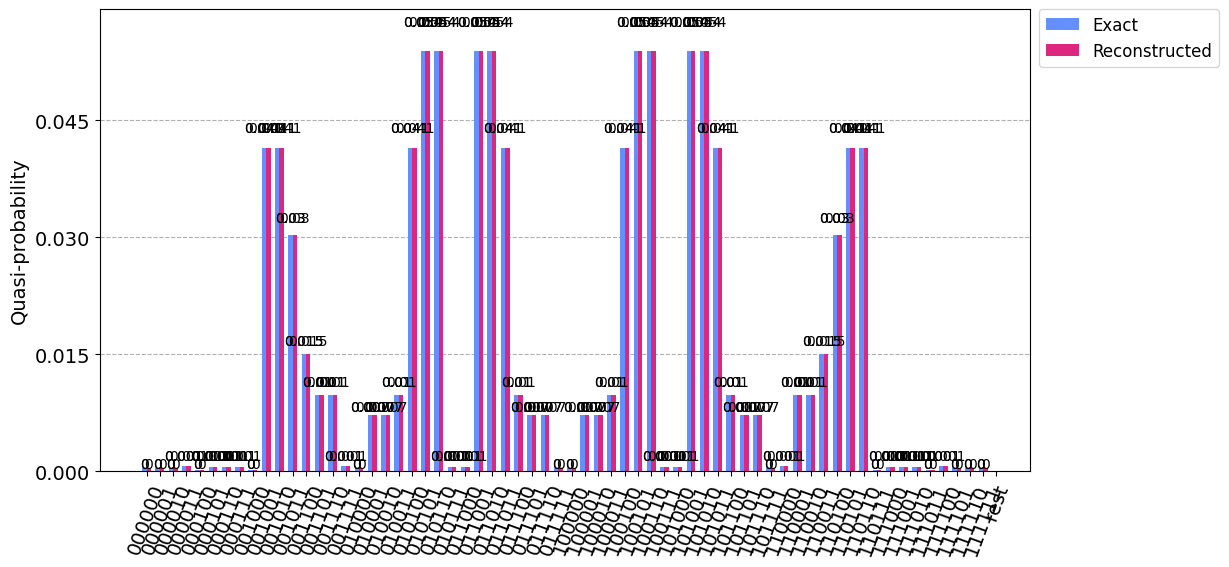

In [69]:
num_qubits = 6
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)
sorted_exact_dict_bitstring = sorted(exact_dict_bitstring.items(), key=lambda x: x[1], reverse=True)
sorted_exact_dict_bitstring = dict(sorted_exact_dict_bitstring)
sorted_reconstructed_dict_bitstring   = sorted(reconstructed_dict_bitstring.items(), key=lambda x: x[1], reverse=True)
sorted_reconstructed_dict_bitstring = dict(sorted_reconstructed_dict_bitstring)
# plot a histogram of the distributions
plot_histogram(
    [sorted_exact_dict_bitstring, sorted_reconstructed_dict_bitstring],
    number_to_keep=64,
    figsize=(12, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

In [70]:
A = sorted_exact_dict_bitstring
B = sorted_reconstructed_dict_bitstring
print(sorted_reconstructed_dict_bitstring)
print(sorted_exact_dict_bitstring)

{'011001': 0.05387922321251466, '011010': 0.053879223212514656, '100101': 0.053879223212514635, '100110': 0.053879223212514635, '101001': 0.05387922321251462, '101010': 0.05387922321251462, '010101': 0.05387922321251461, '010110': 0.05387922321251461, '110101': 0.04142082720647795, '110110': 0.04142082720647795, '100100': 0.041420827206477925, '010100': 0.04142082720647791, '001001': 0.041420827206477905, '001010': 0.041420827206477905, '011011': 0.04142082720647788, '101011': 0.04142082720647787, '001011': 0.030331410436794333, '110100': 0.030331410436794326, '001100': 0.015066302960648799, '110011': 0.015066302960648793, '010011': 0.00970084208181683, '011100': 0.009700842081816825, '100011': 0.009700842081816825, '101100': 0.009700842081816825, '001101': 0.009700842081816815, '001110': 0.009700842081816813, '110010': 0.009700842081816801, '110001': 0.009700842081816792, '010001': 0.0071343721634170975, '010010': 0.007134372163417094, '100010': 0.007134372163417089, '100001': 0.00713

In [97]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [95]:
print(hamiltonian)

SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [104]:
print(subobservables[0])

['IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIZIIZII', 'IZZIIIII', 'ZIZIIIII',
 'ZZIIIIII']


In [106]:
# Original list
#original_list = ['IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIZIIZII', 'IZZIIIII', 'ZIZIIIII', 'ZZIIIIII']
original_list = subobservables[0]
# Initialize two empty lists
list1 = []
list2 = []

# Iterate over the original list
for element in original_list:
    # Split the element into two parts
    part1 = element[:4]  # First 4 characters
    part2 = element[4:]  # Last characters after the first 4
    
    # Append parts to respective lists
    list1.append(part1)
    list2.append(part2)

# Print the resulting lists
print("List 1:", list1)
print("List 2:", list2)


List 1: [Pauli('IIZZ'), Pauli('IZIZ'), Pauli('IZZI'), Pauli('IZII'), Pauli('IIII'), Pauli('IIII'), Pauli('IIII')]
List 2: [Pauli('IIII'), Pauli('IIII'), Pauli('IIII'), Pauli('IIZI'), Pauli('IZZI'), Pauli('ZIZI'), Pauli('ZZII')]


In [109]:
cost_func([x0[:cuts["subcircuits"][0].num_parameters],x0[cuts["subcircuits"][0].num_parameters:cuts["subcircuits"][1].num_parameters]], [cuts["subcircuits"][0],cuts['subcircuits'][1]], [list1,list2], estimator)

2.283203125

In [110]:
cost_func([res.x[:cuts["subcircuits"][0].num_parameters],res.x[cuts["subcircuits"][0].num_parameters:cuts["subcircuits"][1].num_parameters]], [cuts["subcircuits"][0],cuts['subcircuits'][1]], [list1,list2], estimator)

2.341796875

In [ ]:
x0 = [x0[:cuts["subcircuits"][0].num_parameters],x0[cuts["subcircuits"][0].num_parameters:cuts["subcircuits"][1].num_parameters]]

In [113]:
ansatz = [cuts["subcircuits"][0],cuts['subcircuits'][1]]
hamiltonian = [list1,list2]


## Best Cut

Found solution using 2 cuts with a sampling overhead of 256.0.
Wire Cut at index 31
Wire Cut at index 40


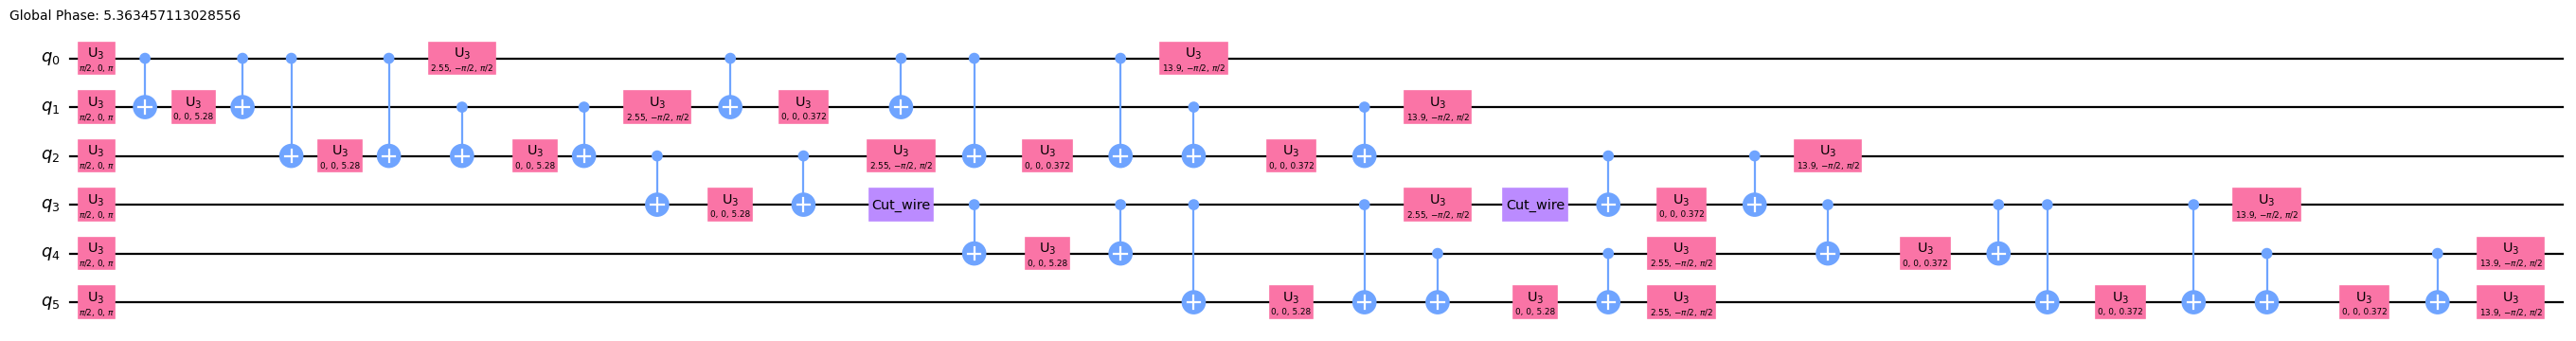

In [75]:
from circuit_knitting.cutting import find_cuts

# Specify settings
optimization_settings = {"rand_seed":111}

# specify device constraints
device_constraints = {"qubits_per_QPU": 4, "num_QPUs": 2}


cut_circuit, metadata = find_cuts(circuit_basis, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

In [76]:
print(hamiltonian)

SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [77]:
from qiskit.quantum_info import PauliList
observables = PauliList(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'])
print(observables)

['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII']


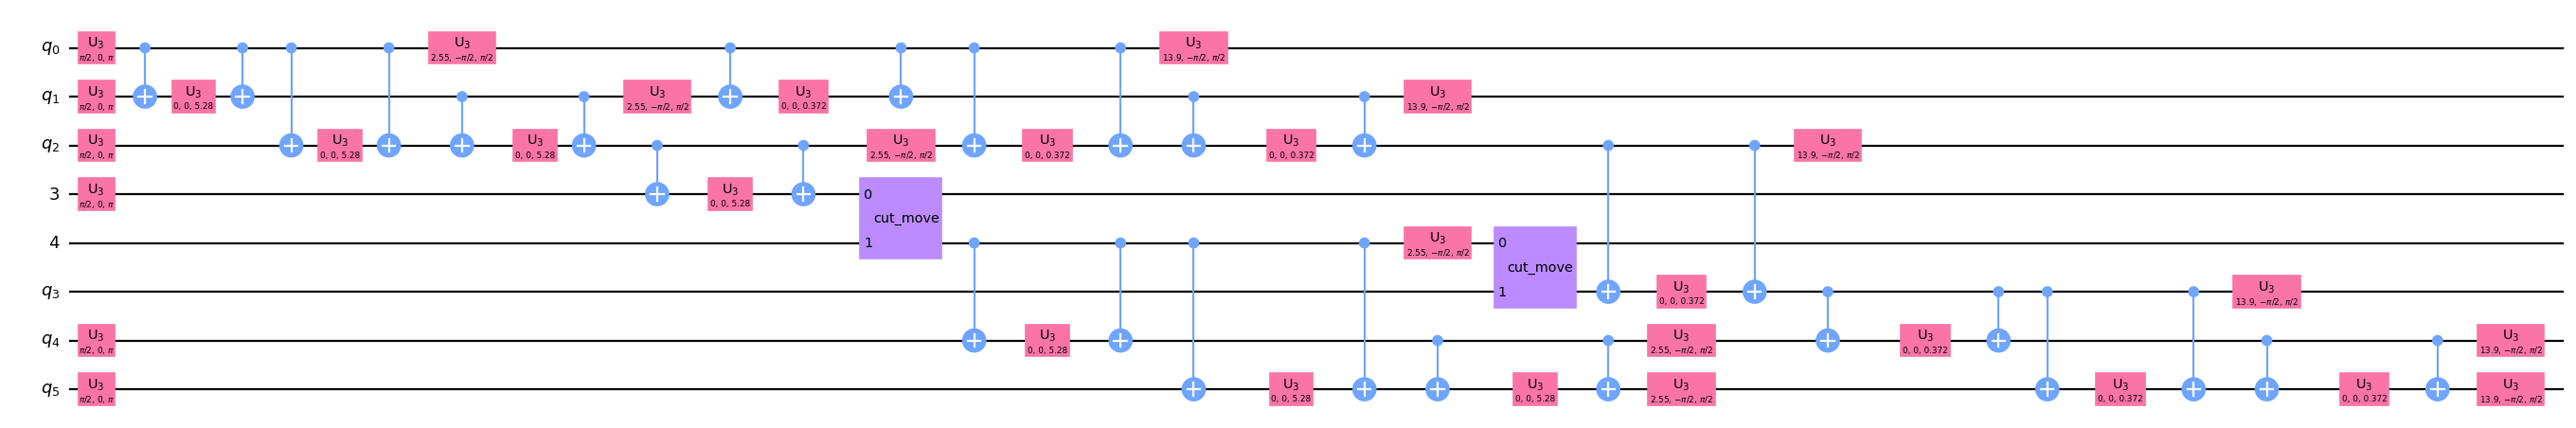

In [78]:
from circuit_knitting.cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observables, circuit_basis, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [79]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)


Sampling overhead: 256.0


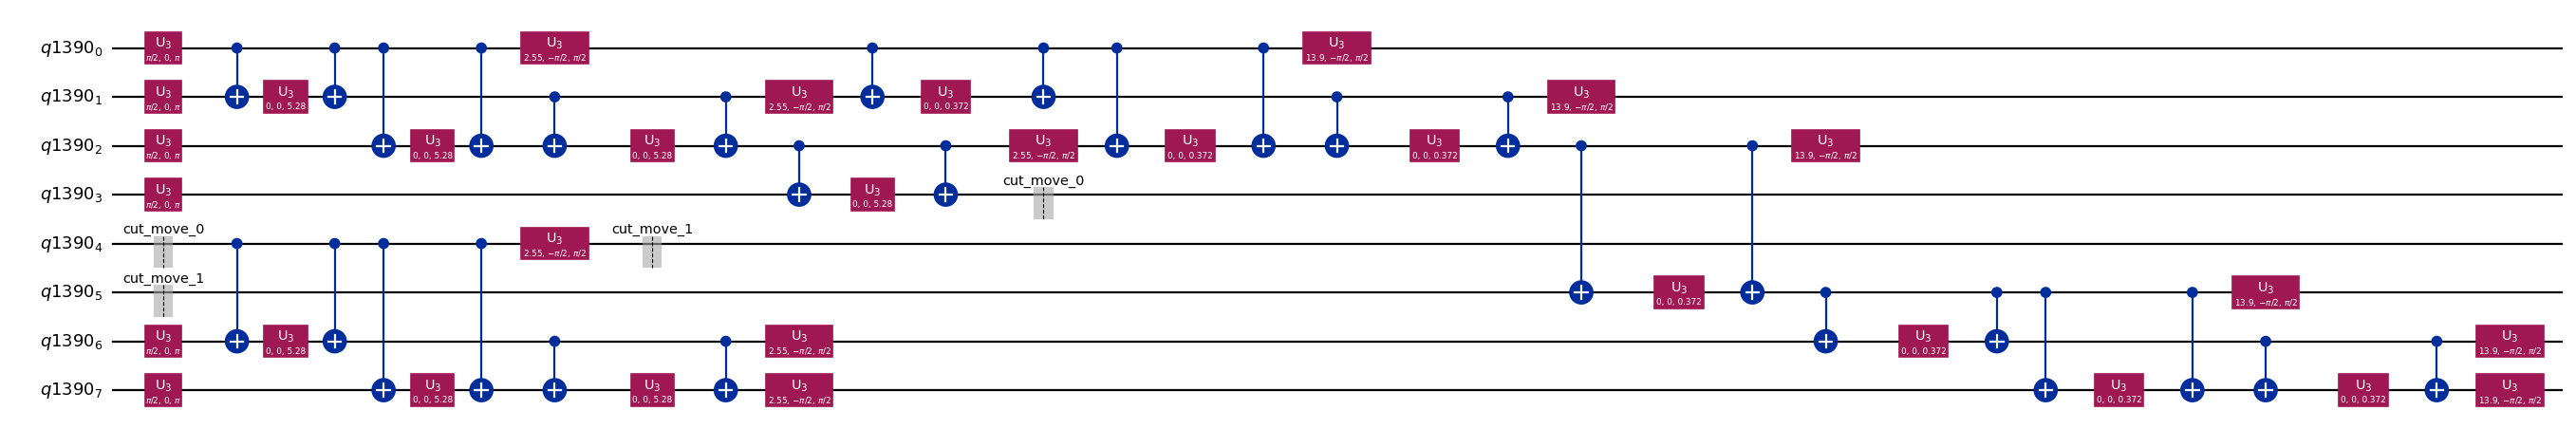

In [80]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8,fold=-1)

In [81]:
print(subobservables[0])

['IIIIIIZZ', 'IIIIIZIZ', 'IIIIIZZI', 'IIZIIZII', 'IZZIIIII', 'ZIZIIIII',
 'ZZIIIIII']
